<a href="https://colab.research.google.com/github/showravj2-create/arima-vs-lstm-time-series-forecasting-/blob/main/01_arima_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

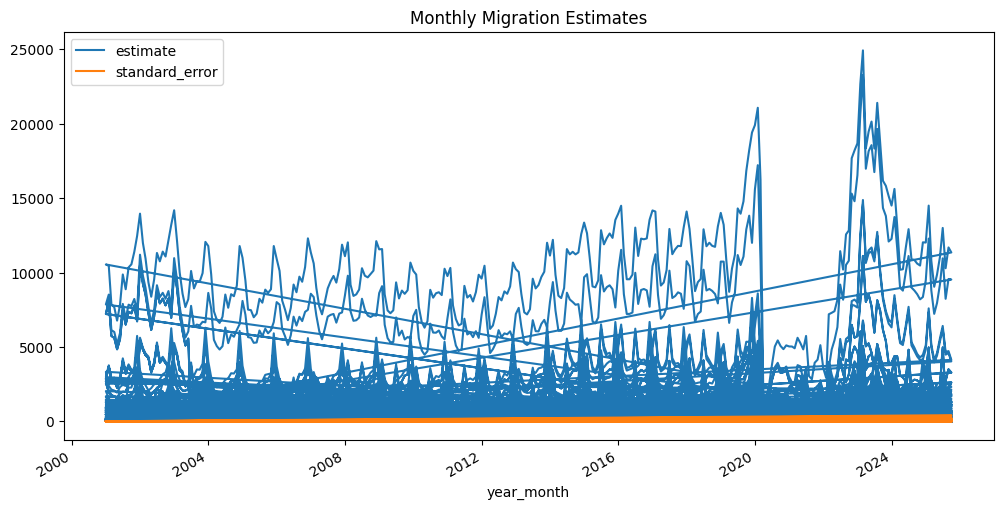

In [ ]:
# 1. Data Loading and Preparation
df = pd.read_csv('/content/international-migration-october-2025-citizenship-by-visa-and-by-country-of-last-permanent-residence.csv', index_col='year_month', parse_dates=True)
df.plot(figsize=(12, 6), title='Monthly Migration Estimates')
plt.show()

In [ ]:
# 2. Stationarity Check (Augmented Dickey-Fuller Test)
def check_stationarity(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')

check_stationarity(df['estimate'].dropna())

KeyboardInterrupt: 

In [ ]:
# 3. Differencing and ACF/PACF Analysis
df_diff = df['estimate'].diff().dropna()
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(df_diff, ax=ax[0])
plot_pacf(df_diff, ax=ax[1])
plt.show()

NameError: name 'df' is not defined

In [ ]:
# 4. SARIMA Model Fitting
train = df[:-12]
test = df[-12:]

# (p, d, q) x (P, D, Q, s) - Seasonal parameters
model = SARIMAX(train['estimate'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit(disp=False)
print(results.summary())

NameError: name 'df' is not defined

In [ ]:
# 5. Forecasting and Evaluation
forecast = results.get_forecast(steps=12).predicted_mean
forecast = pd.Series(forecast.values, index=test.index)
plt.figure(figsize=(12, 6))
plt.plot(train.index[-24:], train['estimate'][-24:], label='Historical (Train)')
plt.plot(test.index, test['estimate'], label='Actual (Test)')
plt.plot(test.index, forecast, label='ARIMA Forecast', color='red')
plt.legend()
plt.title('ARIMA Migration Forecast')
plt.show()

rmse = np.sqrt(mean_squared_error(test['estimate'], forecast))
print(f'Test RMSE: {rmse:.2f}')

NameError: name 'results' is not defined